# Quantum State Preparation

Implementation of the paper [Black-Box Quantum State Preparation without Arithmetic](https://doi.org/10.1103/PhysRevLett.122.020502).

### Problem statement

Given an array of $m$ decimal values 
$$A = (a_0, ..., a_{m-1})$$
such that $a_i \in [0, 1)$, prepare the quantum state 
$$|\psi\rangle = \frac{1}{||A||}\sum_{i=0}^{m-1}a_i|i\rangle$$
where $||A||$ is the normalization constant, and is equal to the magnitude of the vector represented by $A$. $$||A|| = \sqrt{\sum_{i=0}^{m-1}{a_i}^2}$$

We have access to a black-box $amp$ which has the following action - 
$$amp|i\rangle|z\rangle = |i\rangle|z \oplus a_{i}^{(n)}\rangle $$

where $a_{i}^{n}$ is the data $a_{i}$ upto $n$ bits of precision

In [1]:
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import RYGate, MCXGate, ZGate
from qiskit.circuit.controlledgate import ControlledGate
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

import numpy as np

In [2]:
def get_aln(al, n):
    """ Returns the binary form upto n bits of precision of the input decimal data. """
    aln = ""
    for i in range(n):
        al *= 2
        aln += str(int(al))
        al = al - int(al)
        
    # aln = "0." + aln
    return aln

In [3]:
def check_get_aln(aln, al):
    aln = aln[2:]
    check_al = 0
    p = 0.5
    for dig in aln:
        check_al += p*int(dig)
        p /= 2
    print(abs(al - check_al))

In [4]:
def aln_to_gate(aln, n):
    """ Constructs the gate that corresponds to the input binary string - X for bit '1' and I for bit '0'. """
    qc = QuantumCircuit(n)
    for i, dig in enumerate(aln):
        if dig == '1':
            qc.x(i)
    return qc.to_gate(label=aln)    

In [5]:
def get_sv(sv, modified):
    vals = []
    
    if modified == False:
        print("  Out   Data  Flag  Amplitude    Probability")
        for j in range(len(sv.data)):
            if np.abs(sv.data[j]) > 0.00001:
                vals.append((bin(j)[2:].rjust(d+n+1, '0')[::-1][0:d], bin(j)[2:].rjust(d+n+1, '0')[::-1][d:d+n], bin(j)[2:].rjust(d+n+1, '0')[::-1][d+n:], "{:.8f}".format(np.abs(sv.data[j])), "{:.8f}".format(np.abs(sv.data[j])**2)))        
    else:
        print("  Out   Data   Ref  Flag  Amplitude           Probability")
        for j in range(len(sv.data)):
            if np.abs(sv.data[j]) > 0.00001:
                vals.append((bin(j)[2:].rjust(d+2*n+1, '0')[::-1][0:d], bin(j)[2:].rjust(d+2*n+1, '0')[::-1][d:d+n], bin(j)[2:].rjust(d+2*n+1, '0')[::-1][d+n:d+2*n], bin(j)[2:].rjust(d+2*n+1, '0')[::-1][d+2*n:], "{:.8f}".format(np.abs(sv.data[j])), "{:.8f}".format(np.abs(sv.data[j])**2)))        
    vals.sort(key = lambda x: x[0])
    return vals

# Initializing the data

We set $n$ (the precision) and $m$ (the number of data elements), and find $d$ (the number of bits required by the index register to represent $m$ values). 

Since the number of basis states is always a power of $2$, we set the remaining amplitudes as $0$.

In [6]:
n = 3
m = 2
data_m = m
d = int(np.ceil(np.log2(m)))

if d - np.log2(m) != 0:
    data_m = m
    m = 2**d

In [7]:
print(n, m, d, data_m)

3 2 1 2


We take up a toy example, where
$$ A = [0.375, 0.125] $$

The precision ($n$) is set to $3$, hence the binary representation of the data will be calculated upto $3$ places.

The code in this notebook will also work with a randomly generated array of any length and with any precision by - 
1. Updating `n` and `m` in the above cell
2. Uncommenting the first two lines of the next cell
3. Commenting out the third line of the next cell

Alternatively, an array of values may be specified directly and initialzed as `A_vals`, provided `n` and `m` are set correctly in the previous cell, and `m` is a power of $2$

In [8]:
# A_vals = [np.random.rand() for i in range(data_m)]
# A_vals += [0 for i in range(m - data_m)]
A_vals = [0.375, 0.125]
print(f"Data : {A_vals}")
A = [get_aln(A_vals[i], n) for i in range(m)]
print(f"Binary form upto {n} places : {A}")
dec = 2**n
A_vals_n = [int(A[i], 2)/dec for i in range(m)]
print(f"Decimal data after rounding to {n} places : {A_vals_n}")

Data : [0.375, 0.125]
Binary form upto 3 places : ['011', '001']
Decimal data after rounding to 3 places : [0.375, 0.125]


# Grover's state preparation algorithm

#### Step 1 - Initialization
The circuit is initialized with `out`, `data` and `flag`  registers, and with `out` register in equal superposition (to represent indices).

$$
\begin{align}
|\psi_0\rangle &= H^{\otimes d}|0^{\otimes d}\rangle_{out} \otimes |0^{\otimes n}\rangle_{data} \otimes |0\rangle_{flag} \\
|\psi_0\rangle &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}|i\rangle_{out}|0^{\otimes n}\rangle_{data}|0\rangle_{flag}
\end{align}
$$

where $M = 2^d$

In [9]:
def initializer(A, d, m, n, modified):
    """ Initializes a circuit with the appropriate registers for Grover's state preparation method, or the modified version. 
        Also puts the first register in an equal superposition. """
    out = QuantumRegister(d, name = "out")
    data = QuantumRegister(n, name = "data")
    ref = QuantumRegister(n, name = "ref")
    flag = QuantumRegister(1, name = "flag")
    
    if modified:
        circ = QuantumCircuit(out, data, ref, flag, name = "init")
    else:
        circ = QuantumCircuit(out, data, flag, name = "init")
        
    k = int(np.log2(m))
    for i in range(k):
        circ.h([i for i in range(k)])
        
    return circ

In [10]:
qc_orig = initializer(A, d, m, n, False)
sv_orig_0 = Statevector.from_instruction(qc_orig) 

In [11]:
get_sv(sv_orig_0, False)

  Out   Data  Flag  Amplitude    Probability


[('0', '000', '0', '0.70710678', '0.50000000'),
 ('1', '000', '0', '0.70710678', '0.50000000')]

#### Step 2 - Apply black box `amp`

Next, the oracle is applied on the circuit, which prepares the system in the state 

$$
\begin{align}
|\psi_1\rangle &= (amp \otimes I) |\psi_0\rangle \\
|\psi_1\rangle &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}|0\rangle_{flag}
\end{align}
$$

$amp$ has the following action - 
$$amp|i\rangle|z\rangle = |i\rangle|z \oplus a_{i}^{(n)}\rangle $$

In [12]:
def oracle(A, d, m, n):
    """ Loads the data array onto the circuit, controlled by register out as index. """
    circ = QuantumCircuit(d+n, name = "oracle")
    for i in range(m):
        aln_gate = aln_to_gate(A[i], n).control(num_ctrl_qubits = d, label = str(A[i]), ctrl_state = bin(i)[2:].rjust(d, "0")[::-1])
        circ.append(aln_gate, [i for i in range(0, d+n)])
    return circ

In [13]:
black_box = oracle(A, d, m, n)
qc_orig.append(black_box, qargs = [i for i in range(0,d+n)])
sv_orig_1 = Statevector.from_instruction(qc_orig) 

In [14]:
get_sv(sv_orig_1, False)

  Out   Data  Flag  Amplitude    Probability


[('0', '011', '0', '0.70710678', '0.50000000'),
 ('1', '001', '0', '0.70710678', '0.50000000')]

#### Step 3 - Perform rotation operation

The $rot$ operator is applied on the system, which results in the following state

$$
\begin{align}
|\psi_2\rangle &= rot|\psi_1\rangle \\
|\psi_2\rangle &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}(\sin{\theta_i}|0\rangle_{flag} + \cos{\theta_i}|1\rangle_{flag})
\end{align}
$$

where $\theta_i = \arcsin{\frac{a_{i}^{(n)}}{2^n}}$

In the case of the toy example, we have 

$$
\begin{align}
|\psi_2\rangle &= \frac{1}{2}|0\rangle_{out}|011\rangle_{data}(0.375|0\rangle_{flag} + 0.927|1\rangle_{flag}) \\
               &+ \frac{1}{2}|1\rangle_{out}|001\rangle_{data}(0.125|0\rangle_{flag} + 0.992|1\rangle_{flag}) 
\end{align}
$$

In [15]:
def rotate(A_vals_n, d, m):
    """ Applies a CRY(θ_i) Gate with θ_i = ith data element (upto n bits), and controlled by out register as index. """
    circ = QuantumCircuit(d+1, name = "rot")
    for i in range(m):
        theta_i = np.pi - 2*np.arcsin(A_vals_n[i])
        ry_gate = RYGate(theta = theta_i)
        circ.append(ry_gate.control(num_ctrl_qubits = d, label = str(A[i]), ctrl_state = bin(i)[2:].rjust(d, "0")[::-1]), [j for j in range(d+1)]) 
    return circ

In [16]:
rot = rotate(A_vals_n, d, m)
qc_orig.append(rot, qargs = [i for i in range(0,d)] + [d+n])
sv_orig_2 = Statevector.from_instruction(qc_orig)
# qc_orig.measure_all()

In [17]:
get_sv(sv_orig_2, False)

  Out   Data  Flag  Amplitude    Probability


[('0', '011', '0', '0.26516504', '0.07031250'),
 ('0', '011', '1', '0.65550553', '0.42968750'),
 ('1', '001', '0', '0.08838835', '0.00781250'),
 ('1', '001', '1', '0.70156076', '0.49218750')]

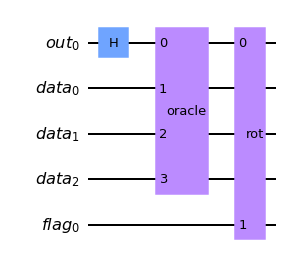

In [18]:
qc_orig.draw('mpl')

#### Step 4 - Perform amplitude amplification

The system now contains the target state, which has the data elements as amplitudes of the basis vectors. However the rotation also introduces some unwanted states (where ```flag``` register is $1$). To eliminate these states and increase the probability of the desired state, we perform amplitude amplification on the state $|\psi_2\rangle$. After amplitude amplification, we will be left with a superposition of the desired state, and an undesired state (with ```flag``` register as $1$), which has a small probability.

In [19]:
def phase_oracle(d, n, modified):
    """ Flips the phase of the state to be amplified. """
    out = QuantumRegister(d, name = "out")
    data = QuantumRegister(n, name = "data")
    ref = QuantumRegister(n, name = "ref")
    flag = QuantumRegister(1, name = "flag")
    
    if modified:
        # Good state has ref and flag registers as all 0s
        circ = QuantumCircuit(out, data, ref, flag, name = "Phase Oracle")
        circ.x(flag)
        circ.append(ZGate().control(num_ctrl_qubits = n, label = "phase", ctrl_state = "0"*n), [i for i in range(d+n, d+(2*n)+1)])
        circ.x(flag)
    else:
        # Good state has flag register as all 0s
        circ = QuantumCircuit(out, data, flag, name = "Phase Oracle")
        circ.x(flag)
        circ.z(flag)
        circ.x(flag)
    
    return circ

In [20]:
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend)

problem = AmplificationProblem(oracle = phase_oracle(d, n, False), state_preparation = qc_orig, objective_qubits = [i for i in range(0,d+n+1)], is_good_state = ['00110', '10010'])
grover = Grover(quantum_instance=quantum_instance)

out = QuantumRegister(d, name = "out")
data = QuantumRegister(n, name = "data")
flag = QuantumRegister(1, name = "flag")
check = ClassicalRegister(d+1, name = "check")

state_prep = QuantumCircuit(out, data, flag, check, name = "State preparation")

# Construct the Grover circuit and apply the Grover operator twice to amplify the good states
grover_ckt = grover.construct_circuit(problem, power = 2)
state_prep.append(grover_ckt, [i for i in range(0, d+n+1)])
sv_orig_3 = Statevector.from_instruction(state_prep)

In [21]:
get_sv(sv_orig_3, False)

  Out   Data  Flag  Amplitude    Probability


[('0', '011', '0', '0.93739986', '0.87871850'),
 ('0', '011', '1', '0.10498331', '0.01102149'),
 ('1', '001', '0', '0.31246662', '0.09763539'),
 ('1', '001', '1', '0.11235934', '0.01262462')]

#### Step 5 - Unprepare `data` register
The `data` register is 'unprepared' by applying the oracle again.

In [22]:
# Unload the data from data register by reapplying the oracle
state_prep.append(black_box, qargs = [i for i in range(0,d+n)])
sv_orig_4 = Statevector.from_instruction(state_prep)

In [23]:
get_sv(sv_orig_4, False)

  Out   Data  Flag  Amplitude    Probability


[('0', '000', '0', '0.93739986', '0.87871850'),
 ('0', '000', '1', '0.10498331', '0.01102149'),
 ('1', '000', '0', '0.31246662', '0.09763539'),
 ('1', '000', '1', '0.11235934', '0.01262462')]

#### Step 6 - Measure

In [24]:
# Measure the flag register
state_prep.measure([out[i] for i in range(d)] + [flag[0]], check)

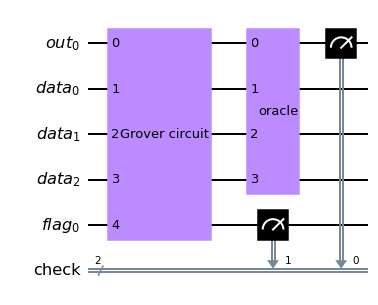

In [25]:
state_prep.draw('mpl')

The algorithm is successful if the `flag` register results in $0$. In this case, the system collapses to the desired state. We observe that the states with value of `flag` as $0$ have high probability after amplitude amplification.

In [26]:
backend = Aer.get_backend('aer_simulator')

res = execute(state_prep, backend, shots=1000).result()
counts = res.get_counts()
print(counts)

{'00': 892, '10': 10, '01': 87, '11': 11}


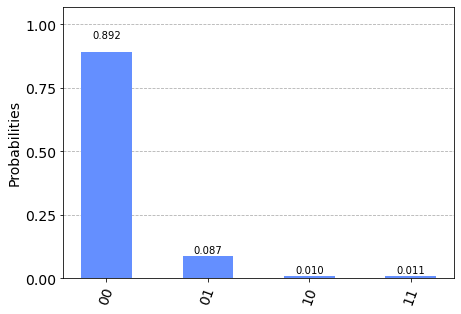

In [27]:
plot_histogram(counts)

Since $A$ corresponds to the probability amplitudes, we plot the square of the data (normalised) to see the expected probability distribution. In the same graph, we plot selected states from `counts` which have `flag` = $0$.

In [28]:
selected_counts = {}
for k in counts.keys():
    # Store in dict if flag bit is 0
    if k[0] == '0':
        selected_counts[k[1]] = counts[k]

In [29]:
A_dict = {}
for i in range(m):
    A_dict[bin(i)[2:].rjust(d, '0')[::-1]] = (A_vals[i])**2

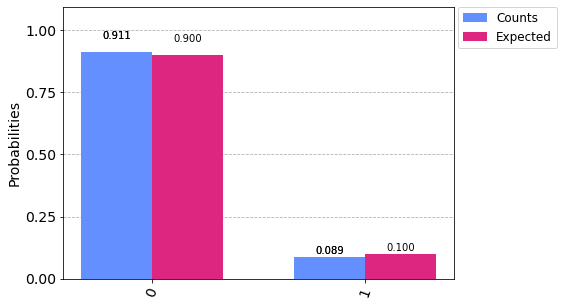

In [30]:
plot_histogram([selected_counts, A_dict], legend = ["Counts", "Expected"])

# Modified state preparation algorithm (without arithmetic)



#### Step 1 - Initialization

The circuit is initialized with `out`, `data`, `ref` and `flag` registers, and with `out` register in equal superposition (to represent indices).

$$
\begin{align}
|\psi_0\rangle &= H^{\otimes d}|0^{\otimes d}\rangle_{out} \otimes |0^{\otimes n}\rangle_{data} \otimes |0^{\otimes n}\rangle_{ref} \otimes |0\rangle_{flag} \\
|\psi_0\rangle &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}|i\rangle_{out}|0^{\otimes n}\rangle_{data}|0^{\otimes n}\rangle_{ref}|0\rangle_{flag}
\end{align}
$$

where $M = 2^d$

In [31]:
qc_modified = initializer(A, d, m, n, True)
sv_modified_0 = Statevector.from_instruction(qc_modified) 

In [32]:
get_sv(sv_modified_0, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '000', '000', '0', '0.70710678', '0.50000000'),
 ('1', '000', '000', '0', '0.70710678', '0.50000000')]

#### Step 2 - Apply black box `amp`

Next, the oracle is applied on the circuit, which prepares the system in the state 

$$
\begin{align}
|\psi_1\rangle &= (amp \otimes I_{n+1}) |\psi_0\rangle \\
|\psi_1\rangle &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}|0^{\otimes n}\rangle_{ref} |0\rangle_{flag}
\end{align}
$$

$amp$ has the following action - 
$$amp|i\rangle|z\rangle = |i\rangle|z \oplus a_{i}^{(n)}\rangle $$

In [33]:
black_box = oracle(A, d, m, n)
qc_modified.append(black_box, qargs = [i for i in range(0,d+n)])
sv_modified_1 = Statevector.from_instruction(qc_modified) 

In [34]:
get_sv(sv_modified_1, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '011', '000', '0', '0.70710678', '0.50000000'),
 ('1', '001', '000', '0', '0.70710678', '0.50000000')]

#### Step 3 - Prepare `ref` in an equal superposition

$$
\begin{align}
|\psi_2\rangle &= (I_{d+n} \otimes H^{\otimes n} \otimes I_{1}) |\psi_1\rangle \\
|\psi_2\rangle &= \frac{1}{\sqrt{MN}}\sum_{i=0}^{M - 1}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}\Biggl(\sum_{j=0}^{N - 1} |j\rangle_{ref} \Biggr) |0\rangle_{flag}
\end{align}
$$

where $N = 2^n$

In [35]:
qc_modified.h([i for i in range(d+n, d+2*n)])
sv_modified_2 = Statevector.from_instruction(qc_modified)

In [36]:
get_sv(sv_modified_2, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '011', '000', '0', '0.25000000', '0.06250000'),
 ('0', '011', '100', '0', '0.25000000', '0.06250000'),
 ('0', '011', '010', '0', '0.25000000', '0.06250000'),
 ('0', '011', '110', '0', '0.25000000', '0.06250000'),
 ('0', '011', '001', '0', '0.25000000', '0.06250000'),
 ('0', '011', '101', '0', '0.25000000', '0.06250000'),
 ('0', '011', '011', '0', '0.25000000', '0.06250000'),
 ('0', '011', '111', '0', '0.25000000', '0.06250000'),
 ('1', '001', '000', '0', '0.25000000', '0.06250000'),
 ('1', '001', '100', '0', '0.25000000', '0.06250000'),
 ('1', '001', '010', '0', '0.25000000', '0.06250000'),
 ('1', '001', '110', '0', '0.25000000', '0.06250000'),
 ('1', '001', '001', '0', '0.25000000', '0.06250000'),
 ('1', '001', '101', '0', '0.25000000', '0.06250000'),
 ('1', '001', '011', '0', '0.25000000', '0.06250000'),
 ('1', '001', '111', '0', '0.25000000', '0.06250000')]

#### Step 4 - Perform compare operation

The $comp$ operator is applied on the system, which results in the following state

$$
\begin{align}
|\psi_3\rangle &= comp|\psi_2\rangle \\
|\psi_3\rangle &= \frac{1}{\sqrt{MN}}\sum_{i=0}^{M - 1}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}\Biggl( \sum_{j=0}^{a_{i}^{n} - 1} |j\rangle_{ref} |0\rangle_{flag} + \sum_{j=a_{i}^{n}}^{N - 1} |j\rangle_{ref} |1\rangle_{flag}\Biggr) 
\end{align}
$$

That is, of the prepared superposition states in `ref`, if the state is $\geq a_i$ for that value of $i$, then the corresponding qubit in `flag` is flipped to the $1$ state.


In the case of the toy example, we have 

$$
\begin{align}
|\psi_3\rangle &= \frac{1}{2}|0\rangle_{out}|011\rangle_{data}\Biggl[\frac{1}{2\sqrt{2}}\Bigl(|000\rangle_{ref} + |001\rangle_{ref} + |010\rangle_{ref} \Bigr)|0\rangle_{flag} + \frac{1}{2\sqrt{2}}\Bigl(|011\rangle_{ref} + |100\rangle_{ref} + |101\rangle_{ref} + |110\rangle_{ref} + |111\rangle_{ref} \Bigr)_{ref}|1\rangle_{flag}\Biggr] \\
               &+ \frac{1}{2}|1\rangle_{out}|001\rangle_{data}\Biggl[\frac{1}{2\sqrt{2}}\Bigl(|000\rangle_{ref} \Bigr)|0\rangle_{flag} + \frac{1}{2\sqrt{2}}\Bigl(|001\rangle_{ref} + |010\rangle_{ref} + |011\rangle_{ref} + |100\rangle_{ref} + |101\rangle_{ref} + |110\rangle_{ref} + |111\rangle_{ref} \Bigr)_{ref}|1\rangle_{flag}\Biggr]
\end{align}
$$

In [37]:
def compare(A_vals_n, d, m, n):
    circ = QuantumCircuit(d+n+1, name = "comp")
    # circ.h([i for i in range(d, d+n)])
    dec = 2**n
    for i in range(m):
        for j in range(int(A_vals_n[i]*dec), dec):
            circ.append(MCXGate(num_ctrl_qubits = d+n, ctrl_state = ((bin(i)[2:].rjust(d, '0') + bin(j)[2:].rjust(n, '0'))[::-1])), [k for k in range(d+n+1)])
        circ.barrier()
    return circ

In [38]:
comp = compare(A_vals, d, m, n)
qc_modified.append(comp, qargs = [i for i in range(0,d)] + [i for i in range(d+n, d+2*n+1)])
sv_modified_3 = Statevector.from_instruction(qc_modified)

In [39]:
get_sv(sv_modified_3, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '011', '000', '0', '0.25000000', '0.06250000'),
 ('0', '011', '010', '0', '0.25000000', '0.06250000'),
 ('0', '011', '001', '0', '0.25000000', '0.06250000'),
 ('0', '011', '100', '1', '0.25000000', '0.06250000'),
 ('0', '011', '110', '1', '0.25000000', '0.06250000'),
 ('0', '011', '101', '1', '0.25000000', '0.06250000'),
 ('0', '011', '011', '1', '0.25000000', '0.06250000'),
 ('0', '011', '111', '1', '0.25000000', '0.06250000'),
 ('1', '001', '000', '0', '0.25000000', '0.06250000'),
 ('1', '001', '100', '1', '0.25000000', '0.06250000'),
 ('1', '001', '010', '1', '0.25000000', '0.06250000'),
 ('1', '001', '110', '1', '0.25000000', '0.06250000'),
 ('1', '001', '001', '1', '0.25000000', '0.06250000'),
 ('1', '001', '101', '1', '0.25000000', '0.06250000'),
 ('1', '001', '011', '1', '0.25000000', '0.06250000'),
 ('1', '001', '111', '1', '0.25000000', '0.06250000')]

#### Step 5 - Unprepare uniform superposition in `ref`

We now unprepare the uniform superposition on `ref` by reapplying the Hadamard transform on the register. Since there are $a_l^{(n)}$ states in the superposition that are entangled with the flag register in the $0$ state, the Hadamard transform will result in exactly $a_l^{(n)}$ states with `ref` and `flag` registers in state $|0^n\rangle_{ref}|0\rangle_{flag}$. The system now has the final desired state, and some unwanted states. Thus, we use the states which have `ref` and `flag` registers as all-zeroes as the good states in amplitude amplification.

The state of the system is now 

$$
\begin{align}
|\psi_4\rangle &= (I_{d+n} \otimes H^{\otimes n} \otimes I_{1}) |\psi_3\rangle \\ \\
               &= \frac{1}{\sqrt{M}}\sum_{i=0}^{M - 1}\frac{a_l^{(n)}}{N}|i\rangle_{out}|a_{i}^{(n)}\rangle_{data}|0^{\otimes n}\rangle_{ref} |0\rangle_{flag} + |\omega\rangle_{out \otimes data \otimes ref \otimes flag}
\end{align}
$$

where $|\omega\rangle$ is the unwanted, unnormalised state that we will be 'supressed' during amplitude amplification

In [40]:
qc_modified.h([i for i in range(d+n, d+2*n)])
sv_modified_4 = Statevector.from_instruction(qc_modified)

In [41]:
get_sv(sv_modified_4, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '011', '000', '0', '0.26516504', '0.07031250'),
 ('0', '011', '100', '0', '0.26516504', '0.07031250'),
 ('0', '011', '010', '0', '0.08838835', '0.00781250'),
 ('0', '011', '110', '0', '0.08838835', '0.00781250'),
 ('0', '011', '001', '0', '0.08838835', '0.00781250'),
 ('0', '011', '101', '0', '0.08838835', '0.00781250'),
 ('0', '011', '011', '0', '0.08838835', '0.00781250'),
 ('0', '011', '111', '0', '0.08838835', '0.00781250'),
 ('0', '011', '000', '1', '0.44194174', '0.19531250'),
 ('0', '011', '100', '1', '0.26516504', '0.07031250'),
 ('0', '011', '010', '1', '0.08838835', '0.00781250'),
 ('0', '011', '110', '1', '0.08838835', '0.00781250'),
 ('0', '011', '001', '1', '0.08838835', '0.00781250'),
 ('0', '011', '101', '1', '0.08838835', '0.00781250'),
 ('0', '011', '011', '1', '0.08838835', '0.00781250'),
 ('0', '011', '111', '1', '0.08838835', '0.00781250'),
 ('1', '001', '000', '0', '0.08838835', '0.00781250'),
 ('1', '001', '100', '0', '0.08838835', '0.00781250'),
 ('1', '00

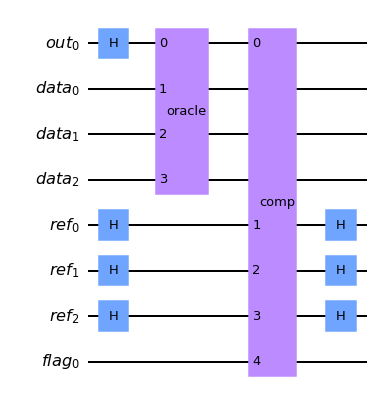

In [42]:
qc_modified.draw('mpl')

#### Step 6 - Perform amplitude amplification

The system now contains the target state, which has the data elements as amplitudes of the basis vectors. However the system also has some unwanted states (where `ref ` and `flag` register are non-zero). To eliminate these states and increase the probability of the desired state, we perform amplitude amplification on the state $|\psi_4\rangle$. After amplitude amplification, we will be left with a superposition of the desired state, and an undesired state, which has a small probability.

In [43]:
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend)

problem = AmplificationProblem(oracle = phase_oracle(d, n, True), state_preparation = qc_modified, objective_qubits = [i for i in range(0,d+2*n+1)], is_good_state = ['00110000', '10010000'])
grover = Grover(quantum_instance=quantum_instance)

out = QuantumRegister(d, name = "out")
data = QuantumRegister(n, name = "data")
ref = QuantumRegister(n, name = "ref")
flag = QuantumRegister(1, name = "flag")
check = ClassicalRegister(d+n+1, name = "check")

modified_state_prep = QuantumCircuit(out, data, ref, flag, check)
# modified_state_prep = qc_modified

modified_state_prep.append(grover.construct_circuit(problem, power = 2), [i for i in range(0, d+2*n+1)])
    
sv_modified_5 = Statevector.from_instruction(modified_state_prep)

In [44]:
(get_sv(sv_modified_5, True))

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '011', '000', '0', '0.93739986', '0.87871850'),
 ('0', '011', '100', '0', '0.04246784', '0.00180352'),
 ('0', '011', '010', '0', '0.01415595', '0.00020039'),
 ('0', '011', '110', '0', '0.01415595', '0.00020039'),
 ('0', '011', '001', '0', '0.01415595', '0.00020039'),
 ('0', '011', '101', '0', '0.01415595', '0.00020039'),
 ('0', '011', '011', '0', '0.01415595', '0.00020039'),
 ('0', '011', '111', '0', '0.01415595', '0.00020039'),
 ('0', '011', '000', '1', '0.07077973', '0.00500977'),
 ('0', '011', '100', '1', '0.04246784', '0.00180352'),
 ('0', '011', '010', '1', '0.01415595', '0.00020039'),
 ('0', '011', '110', '1', '0.01415595', '0.00020039'),
 ('0', '011', '001', '1', '0.01415595', '0.00020039'),
 ('0', '011', '101', '1', '0.01415595', '0.00020039'),
 ('0', '011', '011', '1', '0.01415595', '0.00020039'),
 ('0', '011', '111', '1', '0.01415595', '0.00020039'),
 ('1', '001', '000', '0', '0.31246662', '0.09763539'),
 ('1', '001', '100', '0', '0.01415595', '0.00020039'),
 ('1', '00

#### Step 7 - Unprepare `data` register
The `data` register is 'unprepared' by applying the oracle again.

In [45]:
modified_state_prep.append(black_box, qargs = [i for i in range(0, d+n)])
sv_modified_5 = Statevector.from_instruction(modified_state_prep)

In [46]:
get_sv(sv_modified_5, True)

  Out   Data   Ref  Flag  Amplitude           Probability


[('0', '000', '000', '0', '0.93739986', '0.87871850'),
 ('0', '000', '100', '0', '0.04246784', '0.00180352'),
 ('0', '000', '010', '0', '0.01415595', '0.00020039'),
 ('0', '000', '110', '0', '0.01415595', '0.00020039'),
 ('0', '000', '001', '0', '0.01415595', '0.00020039'),
 ('0', '000', '101', '0', '0.01415595', '0.00020039'),
 ('0', '000', '011', '0', '0.01415595', '0.00020039'),
 ('0', '000', '111', '0', '0.01415595', '0.00020039'),
 ('0', '000', '000', '1', '0.07077973', '0.00500977'),
 ('0', '000', '100', '1', '0.04246784', '0.00180352'),
 ('0', '000', '010', '1', '0.01415595', '0.00020039'),
 ('0', '000', '110', '1', '0.01415595', '0.00020039'),
 ('0', '000', '001', '1', '0.01415595', '0.00020039'),
 ('0', '000', '101', '1', '0.01415595', '0.00020039'),
 ('0', '000', '011', '1', '0.01415595', '0.00020039'),
 ('0', '000', '111', '1', '0.01415595', '0.00020039'),
 ('1', '000', '000', '0', '0.31246662', '0.09763539'),
 ('1', '000', '100', '0', '0.01415595', '0.00020039'),
 ('1', '00

#### Step 8 - Measure

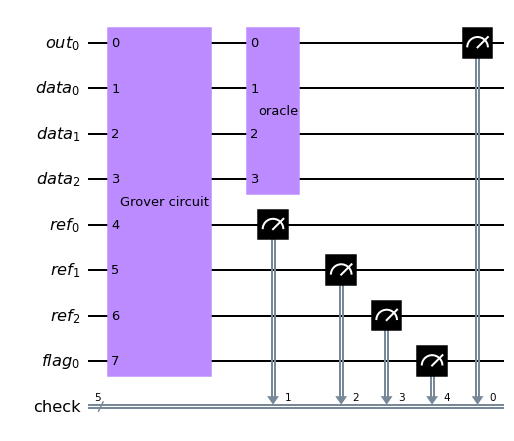

In [47]:
modified_state_prep.measure([out[i] for i in range(d)] + [ref[i] for i in range(n)] + [flag[0]], check)
modified_state_prep.draw('mpl')

The algorithm is successful if the `ref` and `flag` register result in $0^{n+1}$. In this case, the system collapses to the desired state. We observe that the states with value of `ref` and `flag` as $0^{n+1}$ have high probability after amplitude amplification.

In [48]:
backend = Aer.get_backend('aer_simulator')

modified_res = execute(modified_state_prep, backend, shots=1000).result()
modified_counts = modified_res.get_counts()
print(modified_counts)

{'10000': 3, '00001': 100, '11001': 1, '10001': 16, '00000': 877, '10010': 1, '11101': 1, '00010': 1}


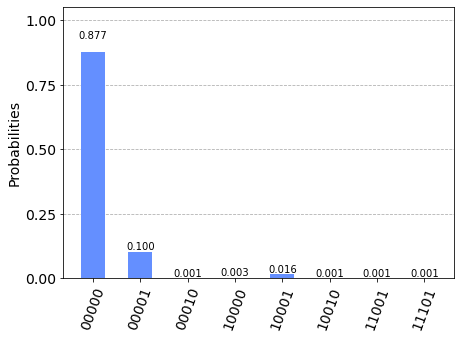

In [49]:
plot_histogram(modified_counts)

Since $A$ corresponds to the probability amplitudes, we plot the square of the data (normalised) to see the expected probability distribution. In the same graph, we plot selected states from `counts` which have `ref` and `flag` = $0^{n+1}$.

In [50]:
selected_modified_counts = {}
for k in modified_counts.keys():
    # Store in dict if ref and flag bits are all 0
    if k[0:n+1] == '0'*(n+1):
        selected_modified_counts[k[n+1:]] = modified_counts[k]

In [51]:
A_dict = {}
for i in range(m):
    A_dict[bin(i)[2:].rjust(d, '0')[::-1]] = (A_vals[i])**2

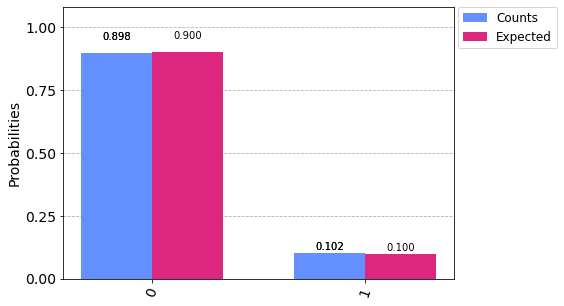

In [52]:
plot_histogram([selected_modified_counts, A_dict], legend = ["Counts", "Expected"])